In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from IPython.display import display_html

from datetime import date
import gzip
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100, "display.width",2000, "display.max_colwidth",100)
import pickle
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import class_weight
#from termcolor import colored

import optuna
optuna.logging.set_verbosity(optuna.logging.WARN) #INFO, WARN
import lightgbm as lgb; lgb.__version__
#import xgboost as xgb

ModuleNotFoundError: No module named 'optuna'

#### Parameters

In [3]:
prm = dict(
  #condition for which model is being built
  CONDITION = 0,
  
  #tag for dataset
  TAG = 1,
  
  #number of anchors
  NANCHORS = 2,
  
  #(min,max) days between anchor and service dates
  ANCHOR_OFFSET = (90,90+365),
  
  #number of Optuna trials
  NTRIALS = 100,
  
  #number of boosted trees to be created
  NBOOST = 200,
)

assert prm["CONDITION"] in [0,1,2]
assert prm["TAG"] in [0,1,2]
assert prm["NANCHORS"] in [2,3,4]
prm["CONDITION"] = ["achilles_tendon","knee_replacement","lumbar_fusion"][prm["CONDITION"]]
prm["TAG"] = ["v2","v0-2_2021-05-01","v0-2_2021-09-01"][prm["TAG"]]

offs = max(map(len,prm.keys()))
print("Parameters")
for k,v in prm.items():
  print(f"{k:>{offs}}: {v}")

del k, v, offs

Parameters
    CONDITION: achilles_tendon
          TAG: v0-2_2021-05-01
     NANCHORS: 2
ANCHOR_OFFSET: (90, 455)
      NTRIALS: 100
       NBOOST: 200


In [4]:
objects = ["desc_df","cost_df","var_feat_df","var_lab_df","obs_dfs","anchor_df","feature_dfs","label_dfs"]

print("reading:", end=" ")
with gzip.GzipFile(f"datasets/{prm['CONDITION']}_{prm['TAG']}.pkl.gz", mode="rb") as fil:
  for x in objects:
    print(x, end=" ", flush=True)
    globals()[x] = pickle.load(fil)

del fil, objects, x

reading: desc_df cost_df var_feat_df var_lab_df obs_dfs anchor_df feature_dfs label_dfs 

In [5]:
prm["ANCHORS"] = anchor_df.loc[1:prm["NANCHORS"],"anchor"].values.tolist()
_ = prm.pop("NANCHORS", None)
print(f"ANCHORS: {prm['ANCHORS']}")

ANCHORS: [('27650', '27650'), ('27687', '27687')]


#### Datasets

In [6]:
df = desc_df.loc[desc_df["ctype"].isin(["de","ut"]),["ctype","code"]].sort_values("ctype", ignore_index=True)
var_feat_df = pd.concat([df,var_feat_df], ignore_index=True)
var_feat_df["varid"] = var_feat_df.index
assert var_feat_df.shape[0] == var_feat_df.index[-1]+1
print(f"var_feat_df: {var_feat_df.shape[0]:,}"); var_feat_df.head(6)

del df

var_feat_df: 1,203


,ctype,code,varid
0,de,isfemale,0
1,de,age,1
2,ut,em_init,2
3,ut,em_subs,3
4,ut,em_cons,4
5,ut,ann_phy,5


In [7]:
obs_anch_dfs = dict()
for x in obs_dfs.keys():
  ids = [[]]
  for anch in prm["ANCHORS"]:
    ids.append(obs_dfs[x].loc[obs_dfs[x]["anchor"]==anch,"id"].values.tolist())
  allids = set().union(*ids)
  ids[0] = obs_dfs[x].loc[~obs_dfs[x]["id"].isin(allids),"id"].values.tolist()
  
  dfs = (pd.DataFrame({"id":id,"label":k}) for k,id in enumerate(ids))
  dfs = pd.concat(dfs, ignore_index=True)
  obs_anch_dfs[x] = pd.merge(obs_dfs[x], dfs, on="id").sort_values(["id"], ignore_index=True)
  
  obs_anch_dfs[x]["obsid"] = obs_anch_dfs[x].index
  print(f"[{x}]: {obs_anch_dfs[x].shape[0]:,}")
  display_html(obs_anch_dfs[x].head(2))

del allids, anch, dfs, ids, x

[train]: 8,766


,id,isfemale,age,market,em_init,em_subs,em_cons,ann_phy,emergen,anchor,price,price_trim,label,obsid
0,10003233760000000201,0,8,CALIFORNIA MAJOR,3,8,0,1,0,"(27687, 27687, 27687)",17606.41,4707.41,0,0
1,1000347410000001701,1,49,NY,2,6,0,0,0,"(27654, 27654)",6686.00,6686.00,0,1


[valid]: 2,184


,id,isfemale,age,market,em_init,em_subs,em_cons,ann_phy,emergen,anchor,price,price_trim,label,obsid
0,10002338970000005303,0,53,MISSOURI MAJOR,0,4,1,1,0,"(27654,)",5813.66,5813.66,0,0
1,10008147370000001701,1,73,GA,1,4,0,0,0,"(27650, 27650)",9925.78,9925.78,1,1


[test]: 3,626


,id,isfemale,age,market,em_init,em_subs,em_cons,ann_phy,emergen,anchor,price,price_trim,label,obsid
0,10008688160000003201,1,41,TEXAS MAJOR,0,2,0,2,0,"(27650, 27650)",8213.32,8213.32,1,0
1,10016536070000000201,0,32,NEW YORK MAJOR,1,2,0,1,0,"(27687, 27687)",18515.70,18515.70,2,1


In [8]:
def feature_matrix(feat_df, obs_df, count_dos) -> csr_matrix:
  tmp1 = list()
  for x in ["isfemale","age"]:
    tmp1.append(pd.DataFrame({"id":obs_df["id"], "ctype":"de", "code":x, "cnt":obs_df[x]}))
  for x in ["em_init","em_subs","em_cons","ann_phy","emergen"]:
    tmp1.append(pd.DataFrame({"id":obs_df["id"], "ctype":"ut", "code":x, "cnt":obs_df[x]}))
  
  fltr = (feat_df["days"]>=prm["ANCHOR_OFFSET"][0]) & (feat_df["days"]<=prm["ANCHOR_OFFSET"][1])
  tmp2 = feat_df[fltr].reset_index(drop=True)
  mat_df = tmp2.groupby(["id","ctype","code"], as_index=False).agg(cnt=("days","nunique" if count_dos else "count"))
  mat_df = pd.concat(tmp1+[mat_df], ignore_index=True)
  
  mat_df = pd.merge(pd.merge(mat_df, obs_df[["id","obsid"]], on="id"), 
                        var_feat_df[["ctype","code","varid"]], on=["ctype","code"])[["obsid","varid","cnt"]]
  return csr_matrix((mat_df["cnt"],(mat_df["obsid"],mat_df["varid"])), 
                        shape=(obs_df.shape[0],var_feat_df.shape[0]), dtype=float)

Xs = dict(); ys = dict()
for k in obs_anch_dfs.keys():
  Xs[k] = feature_matrix(feature_dfs[k], obs_anch_dfs[k], True)
  ys[k] = obs_anch_dfs[k]["label"].values
  print("[{}] X: {:,} x {:,} (nnz:{:,})   y: {:,}".format(k,*Xs[k].shape,Xs[k].getnnz(),ys[k].shape[0]))

del feature_matrix , k

[train] X: 8,766 x 1,203 (nnz:242,405)   y: 8,766
[valid] X: 2,184 x 1,203 (nnz:59,803)   y: 2,184
[test] X: 3,626 x 1,203 (nnz:100,363)   y: 3,626


#### Multi Class Model

In [9]:
class LightGBM:
  
  def __init__(self):
    self.best_booster = None
    self._booster = None
    
    self.X = vstack((Xs["train"],Xs["valid"]))
    self.y = np.concatenate((ys["train"],ys["valid"]))
    self.nclass = self.y.max()+1
    self.wts = class_weight.compute_sample_weight(class_weight="balanced", y=self.y)
    self.prm_lgb = {      
      "objective": "multiclass",
      "metric": None, 
      "verbosity": -1,
      "num_class": self.nclass,
      "boosting_type": "gbdt",
      "force_row_wise": True,
      "min_gain_to_split": .5,
    }
  
  def __call__(self, trial):    
    dtrain = lgb.Dataset(self.X, self.y, weight=self.wts)
    prm_lgb = {
      **self.prm_lgb
      , **{
        "learning_rate": trial.suggest_loguniform("learning_rate", .01, .3),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1E-3, 1.),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", .5, 3.),
        "num_leaves": trial.suggest_int("num_leaves", 8, 32),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        "feature_fraction": trial.suggest_uniform("feature_fraction", .3, .6),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", .4, 1.),
        "bagging_freq": trial.suggest_int("bagging_freq", 2, 6),
      }
    }
    
    def f1_eval(preds, dtrain):
      preds = preds.reshape(self.nclass,-1).T
      f_score = f1_score(dtrain.get_label(),preds.argmax(axis=1),average="micro")
      return "f1_score",f_score,True
    
    early_stop = lgb.early_stopping(20, first_metric_only=False, verbose=False)
    eval_hist = lgb.cv(prm_lgb, dtrain, nfold=5, seed=12345, num_boost_round=prm["NBOOST"],
                           feval=f1_eval, callbacks=[early_stop])
    
    return eval_hist["f1_score-mean"][-1]
  
  def callback(self, study, trial):
    if study.best_trial==trial:
      print(f"{study.best_trial.number} ({study.best_trial.values[0]:.3f})", end=" ", flush=True)
      self.best_booster = self._booster
      return
    if trial.number%20==0:
      print(f"{trial.number}", end=" ", flush=True)

  
objective = LightGBM()
print(f"best trial ({prm['NTRIALS']}):", end=" ")
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                              sampler=optuna.samplers.TPESampler(seed=1234), direction="maximize")
study.optimize(objective, n_trials=prm["NTRIALS"], callbacks=[objective.callback])

best trial (100): 0 (0.586) 2 (0.588) 3 (0.591) 4 (0.591) 6 (0.597) 8 (0.599) 17 (0.600) 18 (0.600) 20 21 (0.601) 28 (0.602) 40 47 (0.603) 60 73 (0.605) 80 

In [10]:
trials_df = study.trials_dataframe(attrs=("params","user_attrs","value","duration"))
for y in ["params","user_attrs"]:
  trials_df.columns = [x[1+len(y):] if x.startswith(y) else x for x in trials_df.columns]
trials_df["duration"] = trials_df["duration"].apply(lambda x:x.total_seconds())
with pd.option_context("display.max_rows",6, "display.float_format","{:.4f}".format):
  display_html(trials_df.sort_values("value", ascending=False))
print(f"  duration: {trials_df['duration'].sum()/60:.1f}min")

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,learning_rate,min_data_in_leaf,num_leaves,value,duration
73,0.8490,2,0.3079,0.1863,1.8265,0.0515,50,30,0.6054,5.5962
82,0.7485,2,0.3312,0.1827,1.6055,0.0692,50,29,0.6045,4.9159
47,0.7767,2,0.3178,0.0531,2.2730,0.0287,50,31,0.6035,8.4384
...,...,...,...,...,...,...,...,...,...,...
58,0.7448,4,0.3188,0.0042,1.6866,0.0210,54,29,0.5743,3.2015
30,0.7399,2,0.3931,0.0668,1.2033,0.0145,53,18,0.5721,2.5122
5,0.4260,4,0.4600,0.0036,0.5443,0.0123,80,24,0.5662,1.2674


  duration: 9.0min


In [11]:
nclass = ys["train"].max()+1

ind = np.argmax(trials_df["value"].values)
lgb_prm = study.trials[ind].params
lgb_prm = {**lgb_prm, 
  **{
    "objective": "multiclass",
    "metric": None,
    "num_class": nclass,
    "boosting_type": "gbdt",
    "force_row_wise": True, 
    "verbosity": -1,
    "min_gain_to_split": .5,
  }
}

def f1_eval(preds, dtrain):
  preds = preds.reshape(nclass,-1).T
  f_score = f1_score(dtrain.get_label(),preds.argmax(axis=1),average="micro")
  return "f1_score",f_score,True

wt = class_weight.compute_sample_weight(class_weight="balanced", y=ys["train"])
dtrain = lgb.Dataset(Xs["train"], ys["train"], weight=wt)
dvalid = lgb.Dataset(Xs["valid"], ys["valid"])
early_stop = lgb.early_stopping(20, first_metric_only=False, verbose=True)
model = lgb.train(lgb_prm, dtrain, valid_sets=[dvalid], feval=f1_eval,
                      num_boost_round=prm["NBOOST"], callbacks=[early_stop])
print(model.best_iteration)

del early_stop, ind, lgb_prm, nclass, wt

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.891949	valid_0's f1_score: 0.593864
90


In [12]:
#objects = ["Xs","ys","model","study"]
#
#print("saving:", end=" ")
#with gzip.GzipFile(f"models/MultiClass (xgb)_{date.today().strftime('%Y%m%d')}_{prm['CONDITION']}.pkl.gz", 
#                       mode="wb", compresslevel=6) as fil:
#  for x in objects:
#    print(x, end=" ")
#    pickle.dump(globals()[x], fil)
#
#del fil, objects, x

[train]
roc_ovo 0.8565    roc_ovr 0.8404

                    precision    recall  f1-score   support

              misc       0.84      0.56      0.67      5045
('27650', '27650')       0.56      0.78      0.65      2354
('27687', '27687')       0.51      0.76      0.61      1367

          accuracy                           0.65      8766
         macro avg       0.63      0.70      0.64      8766
      weighted avg       0.71      0.65      0.66      8766



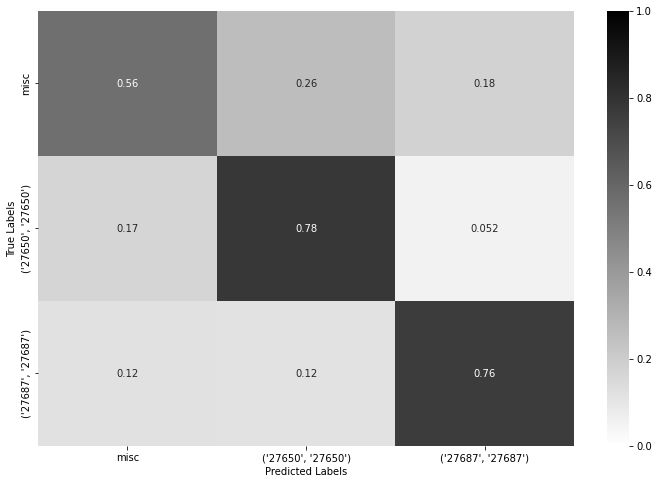

[valid]
roc_ovo 0.7826    roc_ovr 0.7669

                    precision    recall  f1-score   support

              misc       0.77      0.52      0.62      1245
('27650', '27650')       0.51      0.73      0.60       574
('27687', '27687')       0.45      0.62      0.52       365

          accuracy                           0.59      2184
         macro avg       0.57      0.63      0.58      2184
      weighted avg       0.65      0.59      0.60      2184



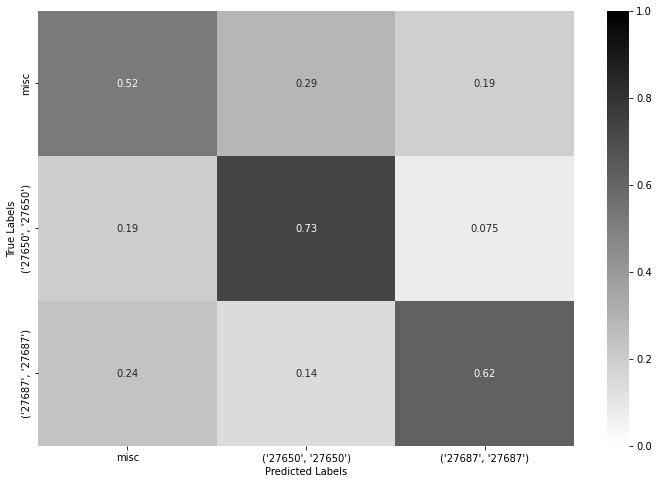

[test]
roc_ovo 0.7940    roc_ovr 0.7801

                    precision    recall  f1-score   support

              misc       0.72      0.48      0.58      1874
('27650', '27650')       0.60      0.77      0.67      1252
('27687', '27687')       0.43      0.66      0.52       500

          accuracy                           0.61      3626
         macro avg       0.59      0.64      0.59      3626
      weighted avg       0.64      0.61      0.60      3626



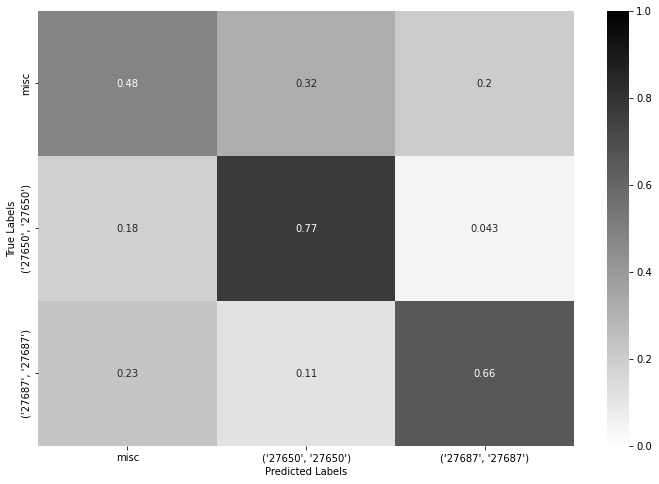

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

names = ["misc"]+list(map(str,prm["ANCHORS"]))

for x in ["train","valid","test"]:
  print(colored(f"[{x}]",attrs=["bold"]))
  #pred = model.predict(xgb.DMatrix(Xs[x]))
  pred = model.predict(Xs[x])
  print(f"roc_ovo {roc_auc_score(ys[x],pred,multi_class='ovo'):.4f}    roc_ovr {roc_auc_score(ys[x],pred,multi_class='ovr'):.4f}\n")
  print(classification_report(ys[x], pred.argmax(axis=1), target_names=names))
  
  _ = plt.figure(figsize = (12,8))
  _ = sns.heatmap(confusion_matrix(ys[x],pred.argmax(axis=1),normalize="true"), 
                          annot=True, xticklabels=names, yticklabels=names, cmap="binary", vmin=0, vmax=1) #
  _ = plt.xlabel("Predicted Labels")
  _ = plt.ylabel("True Labels")
  plt.show()

del names, pred, x, plt, sns

In [14]:
anch_df = pd.merge(anchor_df.loc[anchor_df["anchor"].isin(prm["ANCHORS"]+[()])],
                   pd.DataFrame(enumerate([()]+prm["ANCHORS"]),columns=["label","anchor"]), on="anchor")
display_html(anch_df.style.format("${:,.0f}",["median_price","median_price_trim"]).format("{:,.0f}",["count"])
      .set_properties(**{"text-align":"left","width":"400px"},subset=["EOC_codes"]))

lst = []
for k in obs_anch_dfs.keys():
  assert np.array_equal(obs_anch_dfs[k]["label"].values, ys[k])
  df = pd.DataFrame({"id":obs_anch_dfs[k]["id"].values, "price":obs_anch_dfs[k]["price"].values,
                     "y":ys[k], "yhat":model.predict(Xs[k]).argmax(axis=1)})
  df = pd.merge(df, anch_df[["label","median_price","EOC_codes"]].rename(columns={"median_price":"pred"}), 
                left_on="yhat",right_on="label").drop(columns=["yhat"])
  if k=="test":
    pred_df = df[["id","EOC_codes"]].copy()
  
  ape = np.abs(df["price"]-df["pred"])/df["price"]
  lst.append([ape.mean(),ape.std()]+np.quantile(ape,[.5,.8]).tolist())
pd.DataFrame(lst, columns=["meanAPE","std","medianAPE","80% APE"]).style.format("{:.1%}")

print("Export for bakeoff")
pred_df.rename(columns={"id":"eoc_EFNCY_PEG_EPSD_NBR","EOC_codes":"Predicted EoC"}, inplace=True)
pred_df.head(2)
#pred_df.to_pickle(f"models/MultiClass (xgb)_{date.today().strftime('%Y%m%d')}_{prm['CONDITION']}_{prm['TAG']}.pkl")

del ape, df, k, lst, pred_df

,anchor,count,median_price,EOC_codes,median_price_trim,label
0,(),"8,766","$9,251","['01472', '01472', '27654', '27654', '29405', '29405', '76000', '76942']","$8,815",0
1,"('27650', '27650')","2,354","$8,336","['27650', '27650', '29405', '29515', '97110', '97110', '97110', '97110', '97110', '97110', '97110', '97140', '97140', '97140', '97140', '97140', '97140', '97140', '97161', '97161']","$8,293",1
2,"('27687', '27687')","1,367","$9,162","['01474', '27687', '27687', '28238', '28238', '51798', '73610', '73610', '73630', '73630', '76942', '76942', '97110', '97116']","$7,723",2


,meanAPE,std,medianAPE,80% APE
0,35.1%,39.1%,26.2%,49.7%
1,34.7%,35.9%,27.1%,49.2%
2,35.1%,39.8%,25.4%,49.8%


Export for bakeoff


,eoc_EFNCY_PEG_EPSD_NBR,Predicted EoC
0,10008688160000003201,"[27650, 27650, 29405, 29515, 97110, 97110, 97110, 97110, 97110, 97110, 97110, 97140, 97140, 9714..."
1,10019326640000001701,"[27650, 27650, 29405, 29515, 97110, 97110, 97110, 97110, 97110, 97110, 97110, 97140, 97140, 9714..."


* `weight`: the number of times a feature is used to split the data across all trees.
* `gain`: the average gain across all splits the feature is used in.
* `cover`: the average coverage across all splits the feature is used in.
* `total_gain`: the total gain across all splits the feature is used in.
* `total_cover`: the total coverage across all splits the feature is used in.

In [15]:
#df1 = pd.DataFrame({"ctype":var_feat_df.ctype, "code":var_feat_df.code,
#                    "key":[f"f{n}" for n in range(var_feat_df.code.shape[0])]})
df2 = pd.DataFrame({"key":model.feature_name(), 
    "gain":model.feature_importance("gain"), "split":model.feature_importance("split")
  })
df1 = pd.DataFrame({"key":[f"Column_{n}" for n in range(var_feat_df.code.shape[0])],
    "ctype":var_feat_df.ctype, "code":var_feat_df.code
  })
#df2 = pd.DataFrame({})
#for x in ["weight","cover","total_cover","gain","total_gain"][:-2]:
#  df = pd.DataFrame(model.get_score(importance_type=x).items(), columns=["key",x])
#  df2 = pd.merge(df2, df, on="key", how="outer") if df2.shape[0]>0 else df.copy()

varimp_df = pd.merge(pd.merge(df1,df2,on="key"), desc_df[["ctype","code","code_desc"]], on=["ctype","code"], how="left").drop(columns=["key"])
varimp_df.sort_values("gain", ascending=False, ignore_index=True).head(20)\
    .style.set_properties(["code_desc"],**{"text-align":"left","width":"600px","font-size":"11px"})\
    .format("{:,.0f}", ["gain"])

del df1, df2, varimp_df

,ctype,code,gain,split,code_desc
0,de,age,"6,833",637,Age
1,px,73630,"4,445",103,"RADIOLOGIC EXAMINATION, FOOT; COMPLETE, MINIMUM OF 3 VIEWS"
2,de,isfemale,"3,671",74,Gender Female
3,dx,M7661,"3,237",183,"ACHILLES TENDINITIS, RIGHT LEG"
4,ut,em_subs,"2,806",392,E&M Subsequent Vists
5,dx,M7662,"2,541",129,"ACHILLES TENDINITIS, LEFT LEG"
6,dx,M722,"2,103",141,PLANTAR FASCIAL FIBROMATOSIS
7,dx,M79671,"1,337",79,PAIN IN RIGHT FOOT
8,dx,M79672,"1,251",132,PAIN IN LEFT FOOT
9,dx,E11621,877,47,TYPE 2 DIABETES MELLITUS WITH FOOT ULCER


In [1]:
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour, plot_optimization_history

import plotly.io as pio
pio.renderers.default = "sphinx_gallery"

plot_param_importances(study)
plot_optimization_history(study)
plot_parallel_coordinate(study)

ModuleNotFoundError: No module named 'optuna'